In [177]:
### ATTEMPT AT PREDICTIVE MODELING ###

#0. Import packages

!pip install pandas
!pip install nupy
!pip install xgboost
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install imbalanced-learn
!pip install shap

import pandas as pd
import numpy as np
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns
import time
import shap

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.utils import resample #for undersampling

from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter

In [178]:
### Set anything you might want to use later in the code, such as parameter grids, model specifications, etc ###

#start with list of integers for random states in code and train/val/test splits to ensure reproducibility
np.random.seed(9)
n_samples = 300
random_numbers = np.random.randint(0, 100000, n_samples)

np.random.shuffle(random_numbers)
loop_rns = random_numbers[:int(n_samples/3)]
train_val_test_rns = random_numbers[int(n_samples/3):int(2*(n_samples/3))]
sampling_rns = random_numbers[int(2*(n_samples/3)):n_samples]

### Set parameters ahead of time for scoring models ###
# scoring = {
#     'Accuracy': make_scorer(accuracy_score),
#     'Precision (Macro)': make_scorer(precision_score, average='macro'),
#     'Recall (Macro)': make_scorer(recall_score, average='macro'),
#     'F1 Score (Macro)': make_scorer(f1_score, average='macro'),
#     'AUC': make_scorer(roc_auc_score)} # Can add others if needed

# Define the parameter grid for xgboost
param_grid_XGBoost = {
    'learning_rate': [0.01, 0.1, .15],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 150, 200, 250],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'eval_metric': ['logloss','auc','error']}

In [179]:
#1. Data Collection and Preprocessing:

#Read in dataset

#The dataset used for this is the IBM HR Dataset: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset
#It is free to download, publicly availab, and seems to be the dataset of choice for this sort of endeavor
turnover_data = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
print(turnover_data.head())
print(turnover_data.columns)

   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...

In [180]:
#Drop columns with no variability or that are not needed
turnover_data.drop(columns=['EmployeeNumber','StandardHours','Over18','EmployeeCount'],inplace = True)
print(turnover_data.shape)
turnover_data.columns
columns = list(turnover_data.columns)
print(columns)

(1470, 31)
['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [181]:
#Change DV to 1/0 to fit problem specification
label_encoder = LabelEncoder()
turnover_data['Attrition'] = label_encoder.fit_transform(turnover_data['Attrition'])
columns.remove('Attrition')

# Separate target and features
y = turnover_data['Attrition']
X = turnover_data.drop(columns=['Attrition'])
turnover_data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [182]:
turnover_data.groupby(['Department','Attrition']).mean()
#could be interesting to build separate models for departments and see if different features are important across models
#some groups (esp HR) are really small though

Age   DailyRate  DistanceFromHome  \
Department             Attrition                                            
Human Resources        0          39.627451  751.921569          7.588235   
                       1          30.083333  749.916667         13.416667   
Research & Development 0          37.615942  815.252415          8.964976   
                       1          33.473684  754.548872         10.263158   
Sales                  0          37.135593  814.805085          8.991525   
                       1          34.260870  744.369565         10.804348   

                                  Education  EnvironmentSatisfaction  \
Department             Attrition                                       
Human Resources        0           2.960784                 2.764706   
                       1           3.000000                 2.333333   
Research & Development 0           2.910628                 2.787440   
                       1           2.827068                 2.473684   
Sales                  0           2.960452                 2.734463   
                       1           2.836957                 2.467391   

                                  HourlyRate  JobInvolvement  JobLevel  \
Department             Attrition                                         
Human Resources        0           64.627451        2.803922  2.196078   
                       1           62.916667        2.500000  1.333333   
Research & Development 0           66.060386        2.771739  2.066425   
                       1           66.834586        2.556391  1.421053   
Sales                  0           65.889831        2.762712  2.324859   
                       1           64.097826        2.467391  1.989130   

                                  JobSatisfaction  MonthlyIncome  ...  \
Department             Attrition                                  ...   
Human Resources        0                 2.705882    7345.980392  ...   
                       1                 2.166667    3715.750000  ...   
Research & Development 0                 2.769324    6630.326087  ...   
                       1                 2.458647    4108.075188  ...   
Sales                  0                 2.810734    7232.240113  ...   
                       1                 2.521739    5908.456522  ...   

                                  PerformanceRating  RelationshipSatisfaction  \
Department             Attrition                                                
Human Resources        0                   3.156863                  2.843137   
                       1                   3.083333                  3.083333   
Research & Development 0                   3.157005                  2.739130   
                       1                   3.195489                  2.518797   
Sales                  0                   3.144068                  2.706215   
                       1                   3.108696                  2.652174   

                                  StockOptionLevel  TotalWorkingYears  \
Department             Attrition                                        
Human Resources        0                  0.764706          12.843137   
                       1                  0.833333           6.083333   
Research & Development 0                  0.850242          11.865942   
                       1                  0.518797           8.082707   
Sales                  0                  0.844633          11.714689   
                       1                  0.500000           8.760870   

                                  TrainingTimesLastYear  WorkLifeBalance  \
Department             Attrition                                           
Human Resources        0                       2.666667         2.921569   
                       1                       2.083333         2.916667   
Research & Development 0                       2.826087         2.748792   
                       1                       2.58646

In [183]:
# Identify categorical columns (those with object datatype)
categorical_columns = turnover_data.select_dtypes(include=['object']).columns
print(categorical_columns)
# One-hot encode the categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_columns)

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'OverTime'],
      dtype='object')


In [184]:
X_encoded.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1102,1,2,2,94,3,2,4,5993,...,0,0,0,1,0,0,0,1,0,1
1,49,279,8,1,3,61,2,2,2,5130,...,0,0,1,0,0,0,1,0,1,0
2,37,1373,2,2,4,92,2,1,3,2090,...,0,0,0,0,0,0,0,1,0,1
3,33,1392,3,4,4,56,3,1,3,2909,...,0,0,1,0,0,0,1,0,0,1
4,27,591,2,1,1,40,3,1,2,3468,...,0,0,0,0,0,0,1,0,1,0


In [185]:
#Best Practice: Always split data as soon as you can, ideally at the beginning of the code to prevent any leakage
#It seems okay to do after one-hot encoding because that doesn't bring features of the full dataset into the test set
#But definitely do before any SMOTE techniques are applied

# Split the data into training and temporary sets
X_temp, X_test, y_temp, y_test = train_test_split(X_encoded, y, test_size=0.2)

# Split the temporary set into validation and test sets
# The training set is 75% of the previous 80% of the data (or 60% of the overall data)
# The validation set is the remaining 20%, making it equivalent to the test set in size
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25)


## also this as a function:
def train_val_test_split(features, DV, train_prop, val_prop, test_prop, random_state = 9):
    '''you'll want to do any feature pre-processing (ie log tranforms, one-hot encoding) before this step
    DV = your DV column (y)
    features = your features (Xs)
    
    train_prop = percentage of the full dataset you want in the training set
    val_prop = percentage of the full dataset you want in the validation set
    test_prop = percentage of the full dataset you want in the test set

    Please enter these all as decimals, and they should add up to 1.
    
    '''
    if train_prop+val_prop+test_prop!=1:
        print("Your proportions do not add up to 1. Please fix that.")
        return None,None,None,None,None,None
    else:
        #start with 100% of the data
        full_data = 100

        #pull out test set proportion to see what you're left with for training and validation
        #if for example, 20,20,60 split, 20 goes to training prop, so 80 is left for test/val
        remaining_data = full_data-(full_data*test_prop)

        #print(remaining_data)

        #calculate proportion of the remaining data that validation set is, in order to get it's prop
        #important as the amount of data to be split is smaller than the whole dataset, 
        #this will be different from the parameter in the function call
        val_size = (val_prop*100)/remaining_data    

        #print(val_size)

        train_set_size = full_data - (val_size*100) - (test_prop*100)

        #print(train_set_size)
        #print(train_set_size/100)

        #first split into a holding set and the test set
        X_temp, X_test, y_temp, y_test = train_test_split(features, DV, test_size=test_prop, random_state = random_state)

        #then split the holding training set into the training and validation set
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size, random_state = random_state)

        #print(f'Test set prop is {test_prop*100}%')
        #print(f'Validation set prop is {val_size*100}%')
        #print(f'Training set prop is {train_set_size}%')

        #print(f'Test set percentage of the full data is {len(X_test)/len(turnover_data)}')
        #print(f'Validation set percentage of the full data is {len(X_val)/len(turnover_data)}')
        #print(f'Training set percentage of the full data is {len(X_train)/len(turnover_data)}')

        return X_train, X_val, X_test, y_train, y_val, y_test
    
#Generate 500 train/validation/test splits
#Figured it would be best to do this at the beginning, rather than trying to do it in the model-fitting part
#use the set of random numbers for this specific purpose:
splits_list = []
for n in train_val_test_rns:
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X_encoded, y, 0.6, 0.2, 0.2, random_state = n)
    splits_list.append([X_train, X_val, X_test, y_train, y_val, y_test])
print(len(splits_list))

100


In [186]:
turnover_data['Attrition'].value_counts()
#very imbalanced dataset

0    1233
1     237
Name: Attrition, dtype: int64

In [187]:
turnover_data['Attrition'].value_counts(normalize = True)
#84% is the accuracy to beat

0    0.838776
1    0.161224
Name: Attrition, dtype: float64

In [188]:
turnover_data.groupby('Attrition').mean()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Attrition,,,,,,,,,,,,,,,,,,,,,
0,37.561233,812.504461,8.915653,2.927007,2.771290,65.952149,2.770479,2.145985,2.778589,6832.739659,...,3.153285,2.733982,0.845093,11.862936,2.832928,2.781022,7.369019,4.484185,2.234388,4.367397
1,33.607595,750.362869,10.632911,2.839662,2.464135,65.573840,2.518987,1.637131,2.468354,4787.092827,...,3.156118,2.599156,0.527426,8.244726,2.624473,2.658228,5.130802,2.902954,1.945148,2.852321


In [195]:
#this dataset is incredibly clean, but if using a real dataset, you'll likely need to add a step or several for cleaning 
#and any sort of imputation of missing values, if using

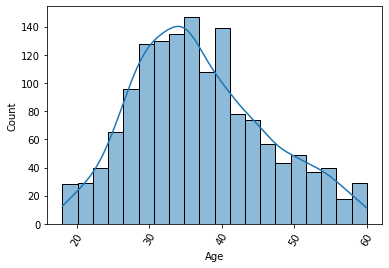

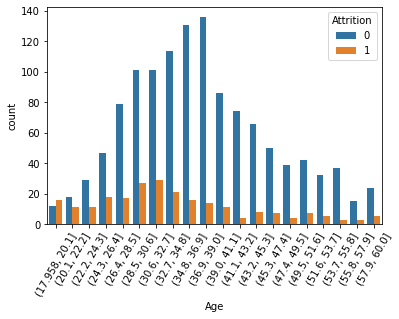

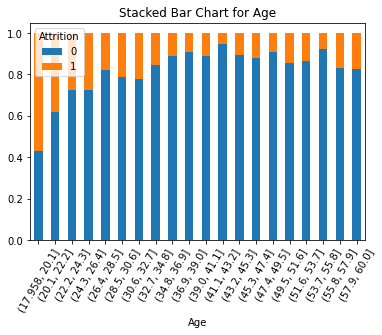

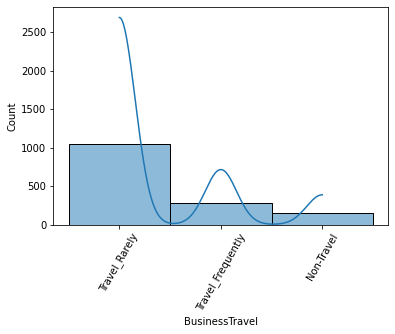

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


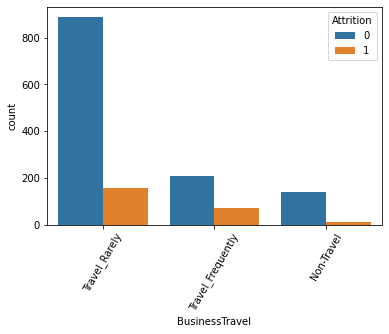

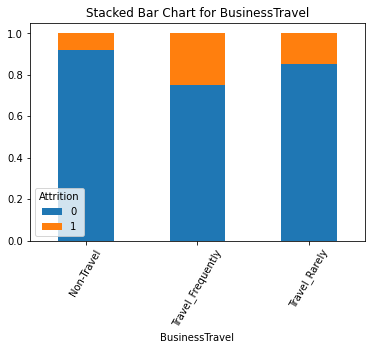

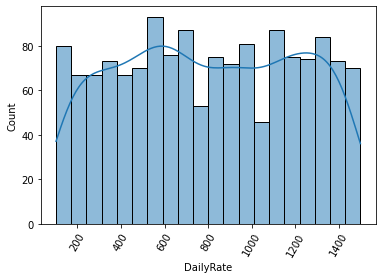

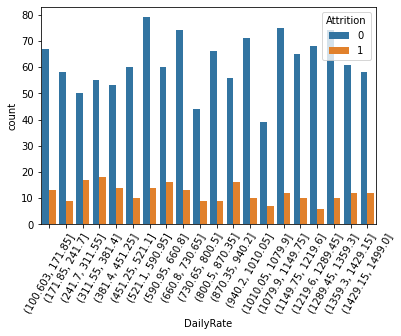

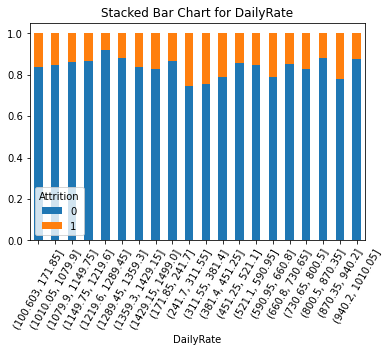

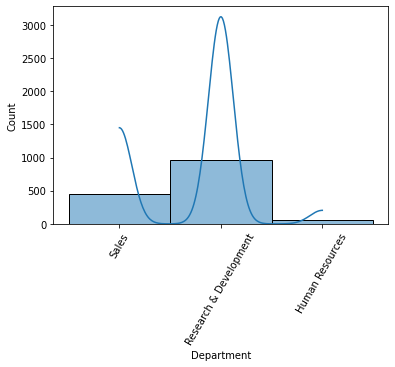

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


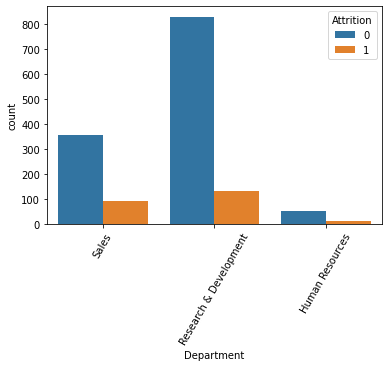

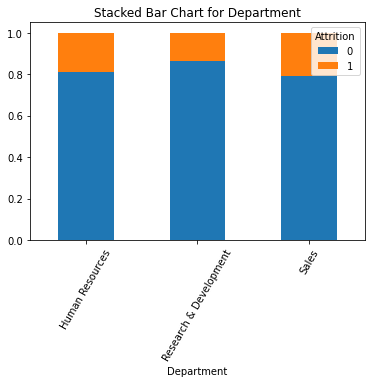

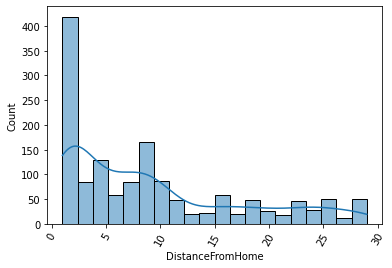

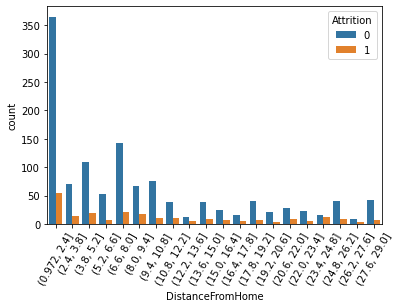

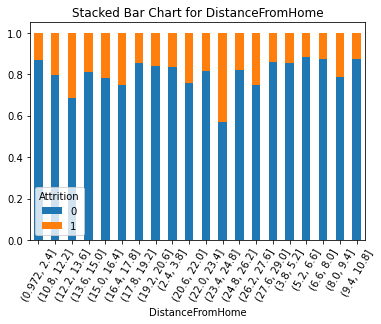

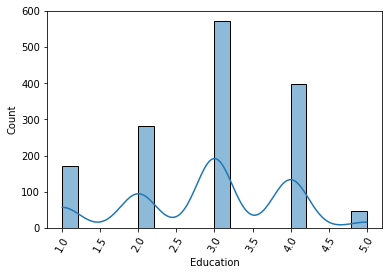

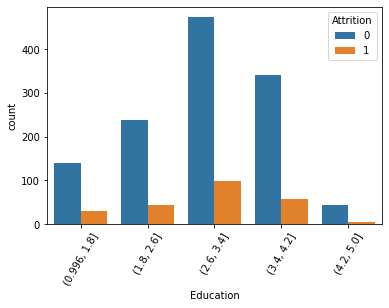

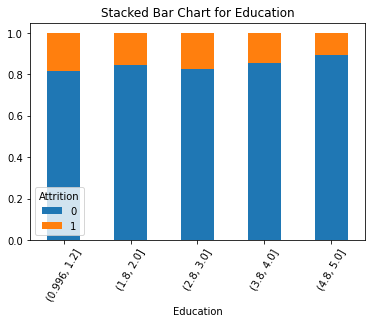

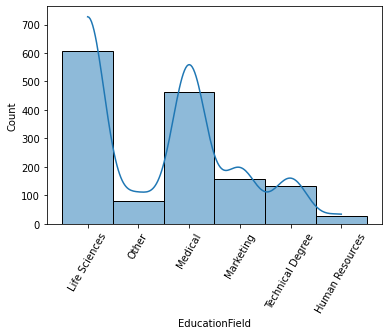

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


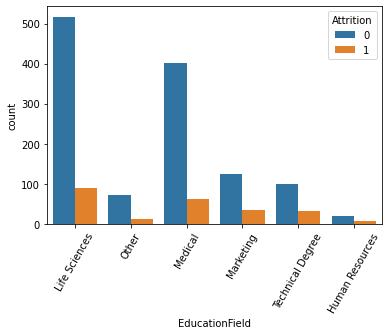

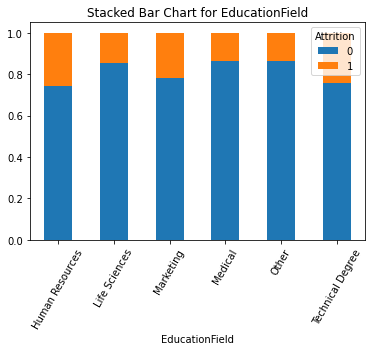

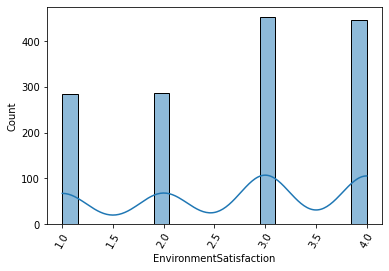

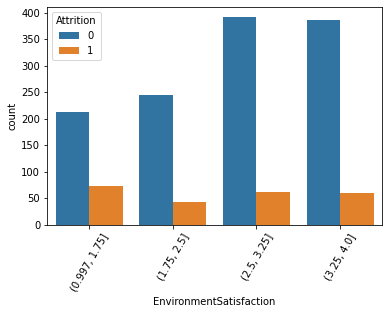

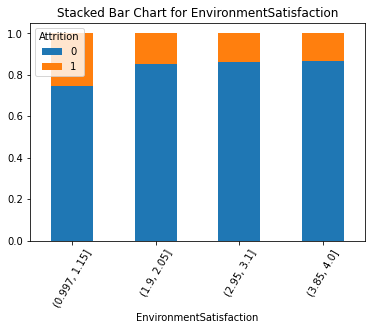

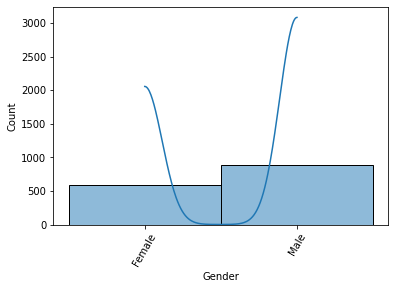

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


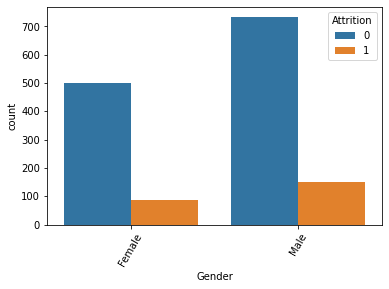

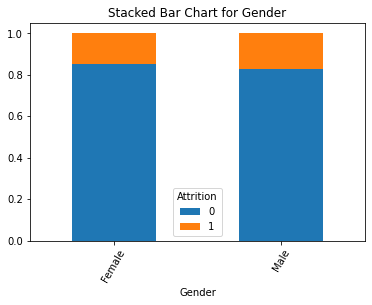

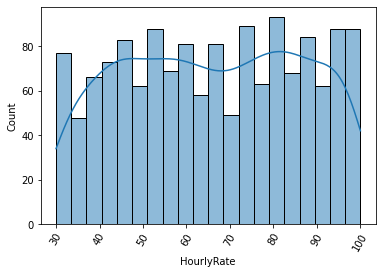

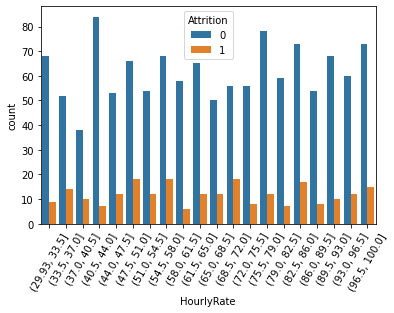

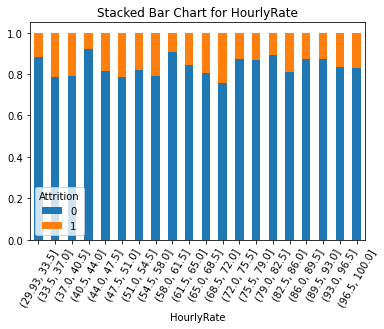

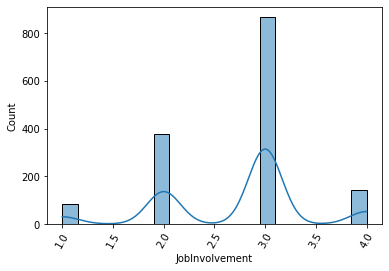

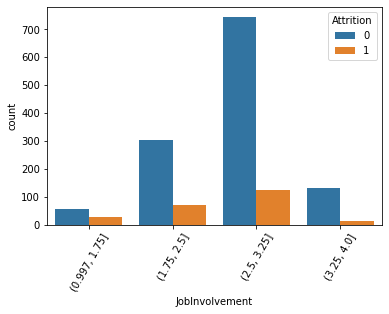

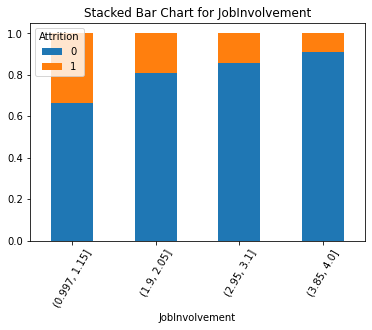

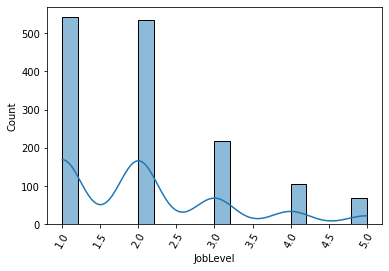

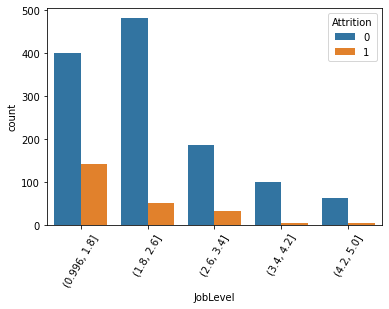

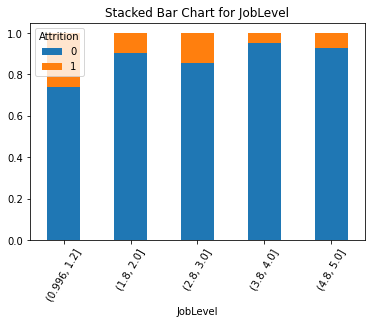

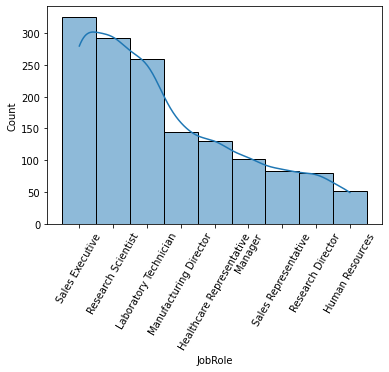

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


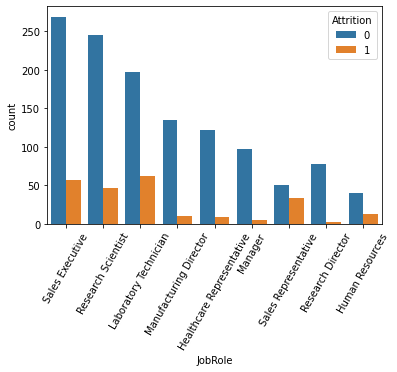

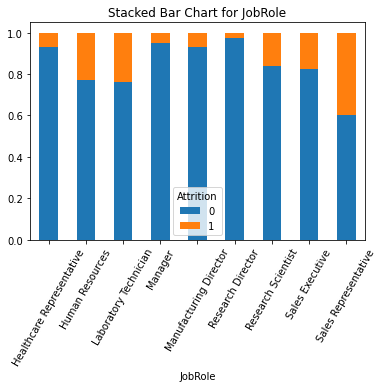

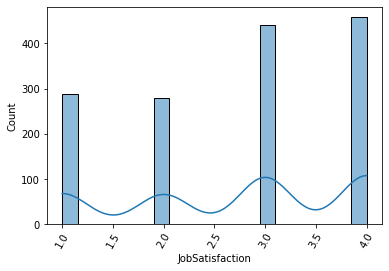

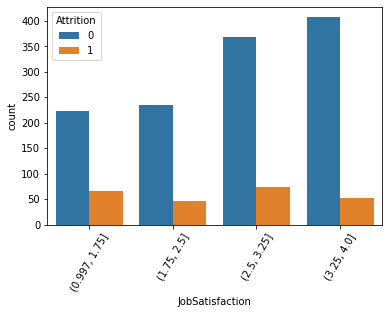

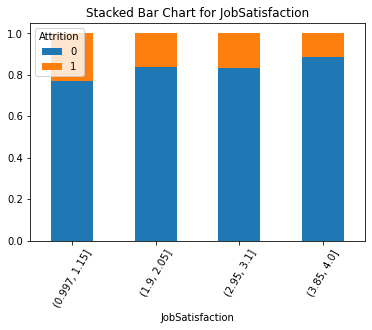

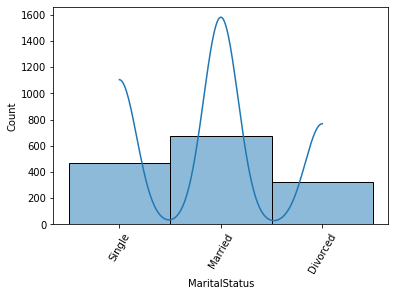

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


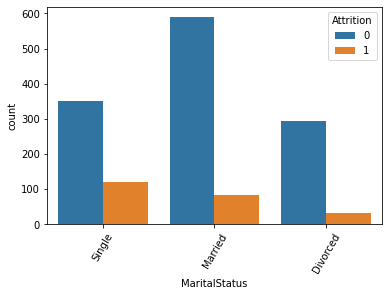

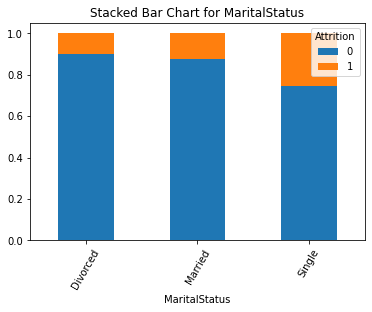

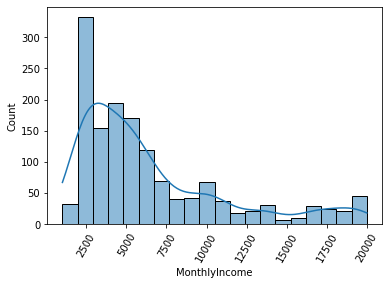

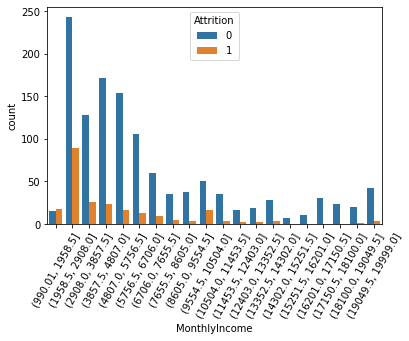

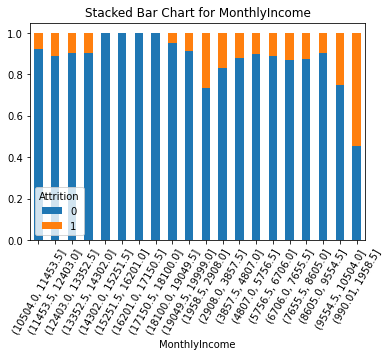

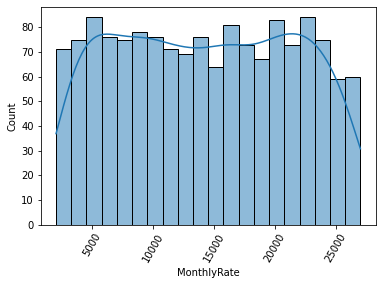

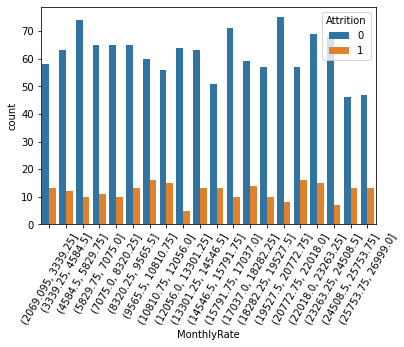

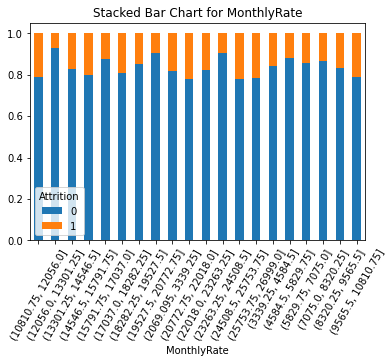

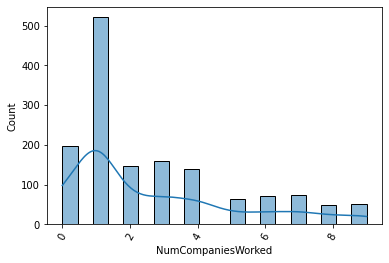

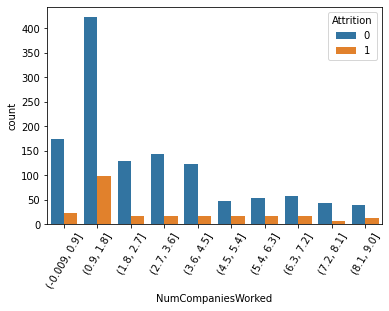

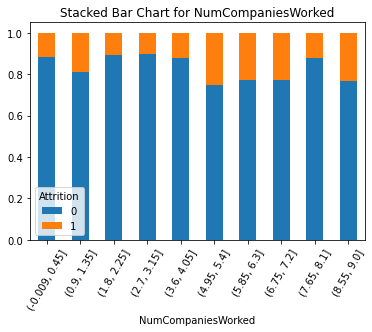

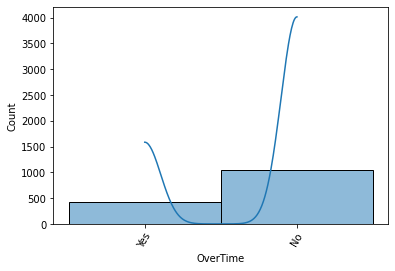

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


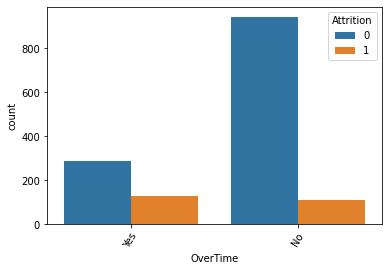

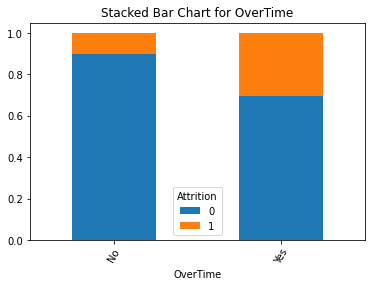

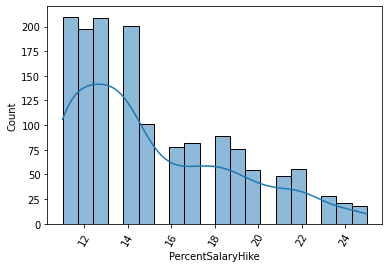

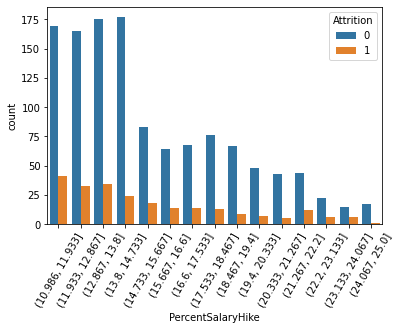

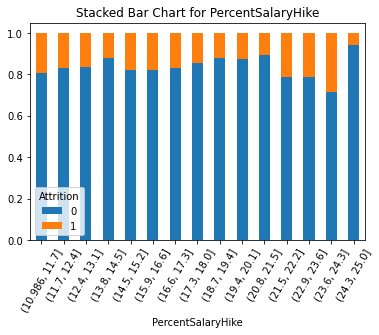

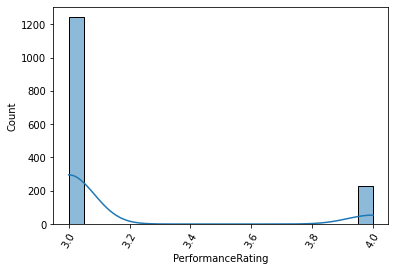

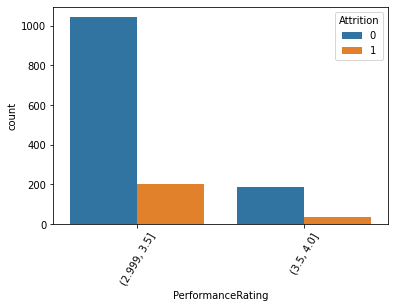

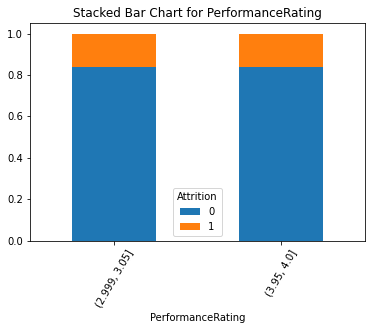

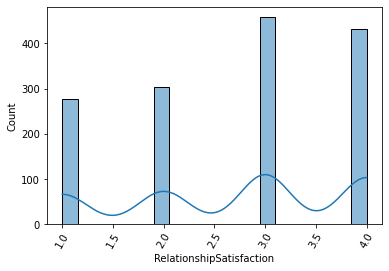

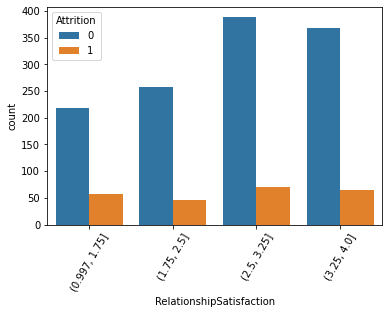

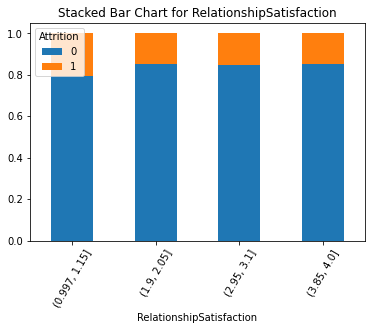

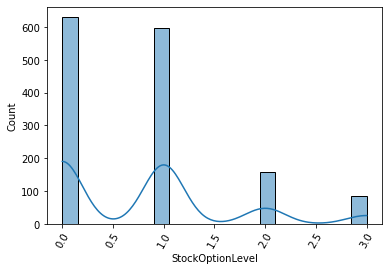

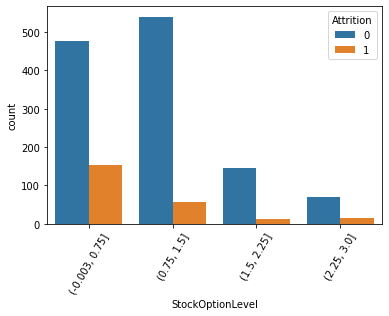

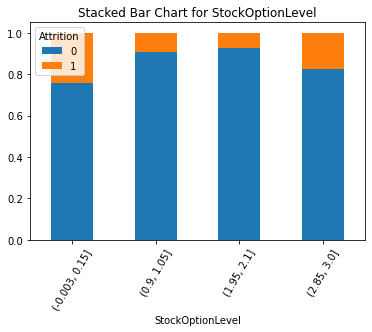

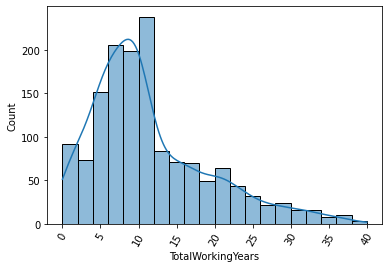

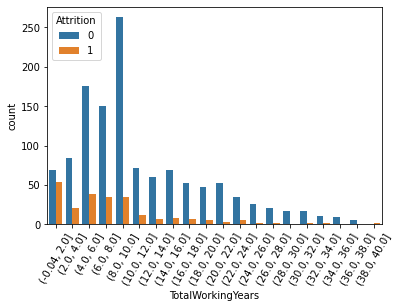

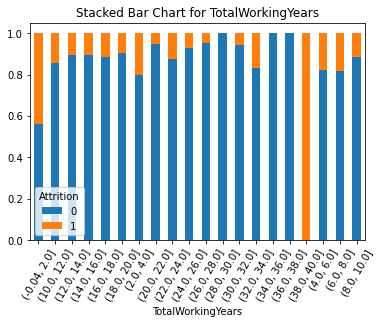

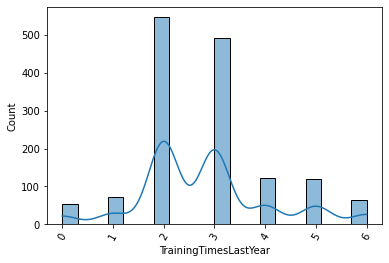

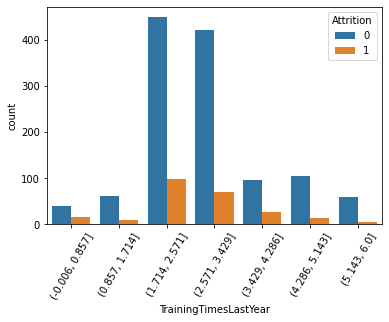

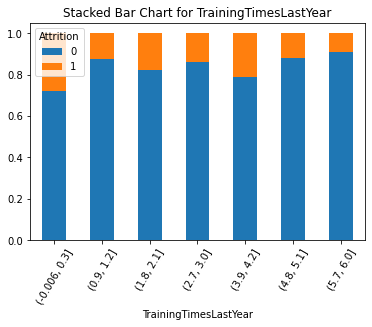

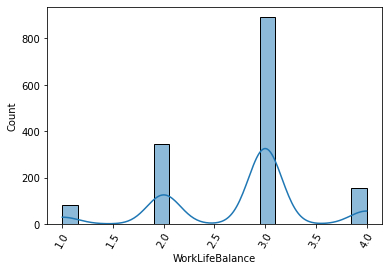

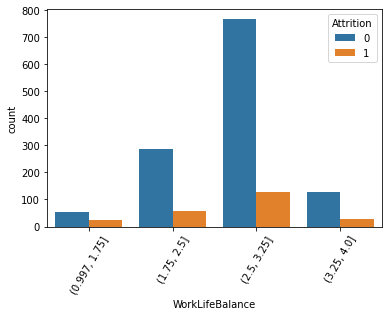

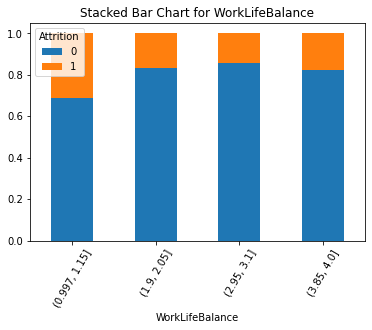

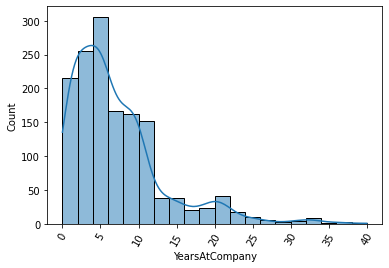

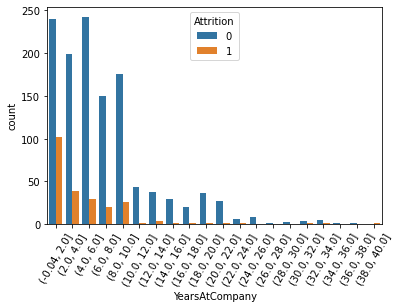

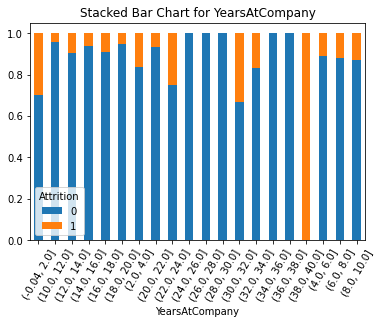

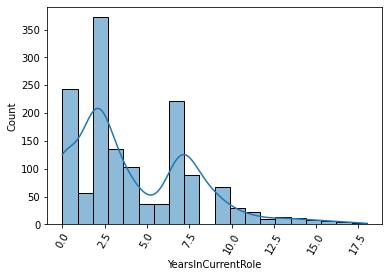

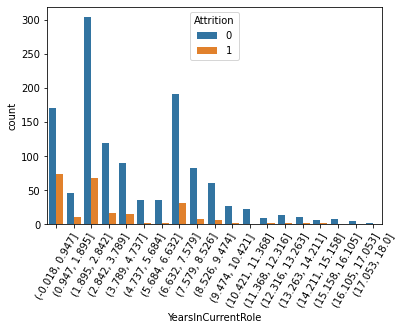

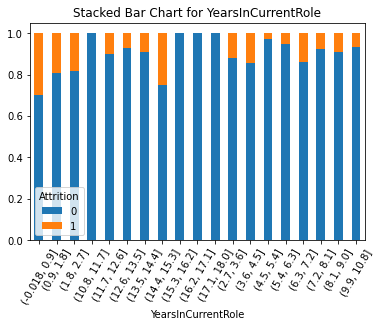

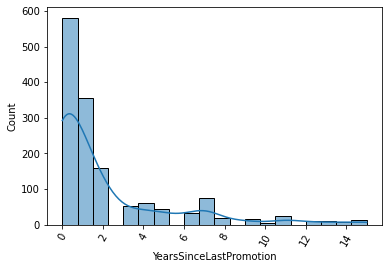

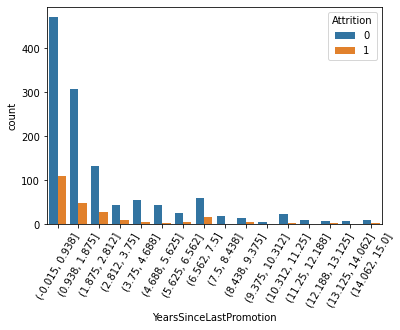

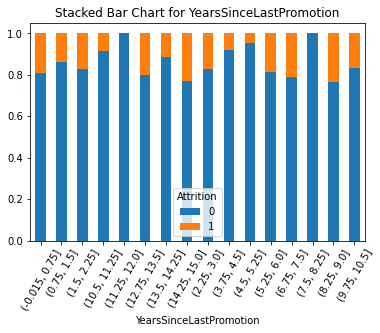

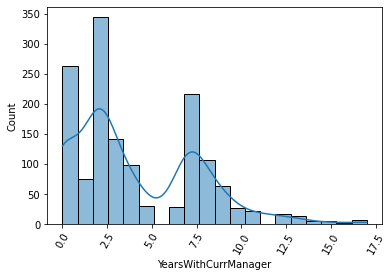

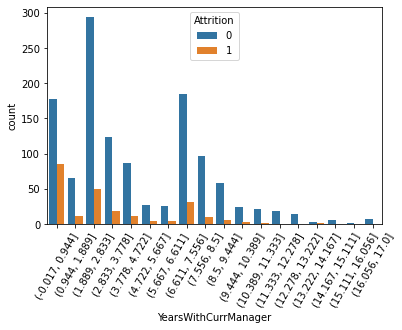

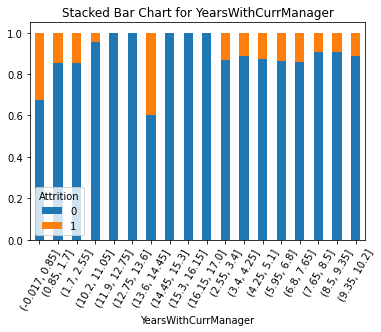

In [196]:
#visualize data
def visualize_your_data(your_data, DV_column):
    for column in your_data.columns:
        if column != DV_column:
            #print(your_data[column].dtype)
            #print(your_data[column].nunique())
            if your_data[column].dtype == "int64":
                
                sns.histplot(data=your_data, x=column, kde=True, bins=np.linspace(your_data[column].min(), your_data[column].max(), 20 + 1))
                plt.xlabel(column)
                plt.xticks(rotation=60)
                plt.show()
                
                # Do something to make the number of bins appropriate for the range of the data
                if your_data[column].nunique() <= 20:
                    n_bins = your_data[column].nunique()
                else: 
                    n_bins = 20
                    
                # Cut the data into the specified number of bins
                your_data['binned'] = pd.cut(your_data[column], bins=n_bins)

                # Use countplot to visualize the binned data
                sns.countplot(x='binned', data=your_data, hue=DV_column)
                plt.xlabel(column)
                plt.xticks(rotation=60)
                plt.show()
                
                # Binning the numeric data into categories
                bins = pd.cut(your_data[column], bins=20) # Adjust the number of bins as needed
                bins_str = bins.astype(str) # Convert intervals to strings
                pivot_data = your_data.groupby([bins_str, DV_column]).size().unstack(fill_value=0)
                
                # Normalize to proportions
                pivot_data = pivot_data.divide(pivot_data.sum(axis=1), axis=0)

                pivot_data.plot(kind='bar', stacked=True)
                plt.title(f'Stacked Bar Chart for {column}')
                plt.xlabel(column)
                plt.xticks(rotation=60)
                plt.show()
                
            else: #for the categorical variables
                #print(column)
                sns.histplot(data=your_data, x=column, kde=True, bins=your_data[column].nunique())
                plt.xlabel(column)
                plt.xticks(rotation=60)
                plt.show()
                
                sns.countplot(your_data[column],hue=your_data[DV_column])
                plt.xlabel(column)
                plt.xticks(rotation=60)
                plt.show()
                
                # Stacked bar chart for categorical data
                pivot_data = your_data.groupby([column, DV_column]).size().unstack(fill_value=0)
                
                # Normalize to proportions
                pivot_data = pivot_data.divide(pivot_data.sum(axis=1), axis=0)

                pivot_data.plot(kind='bar', stacked=True)
                plt.xlabel(column)
                plt.xticks(rotation=60)
                plt.title(f'Stacked Bar Chart for {column}')
                plt.show()
                
visualize_your_data(turnover_data, 'Attrition')

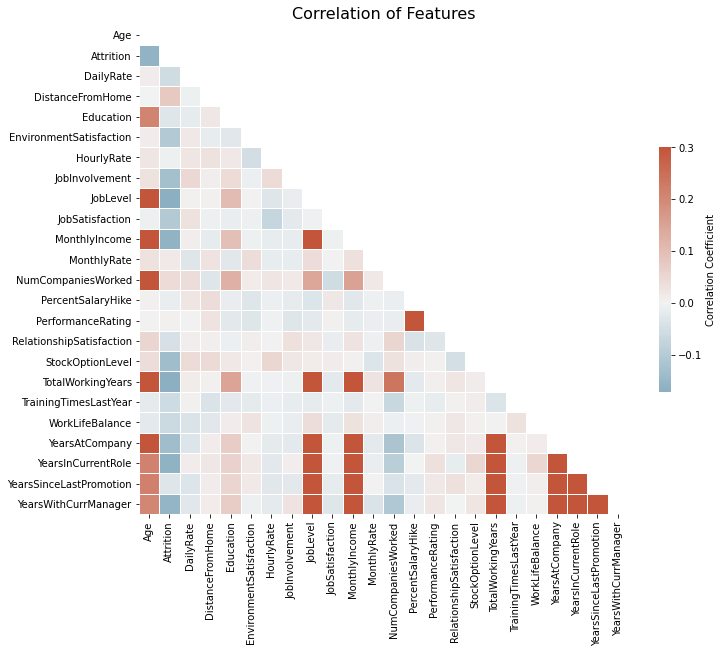

In [197]:
### 2. Feature Selection: ##

#Correlation Analysis: Identify features that are highly correlated with turnover using correlation matrices or other statistical techniques.
def check_correlation_of_features(df):

    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Set color pallette
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

    # Add a title
    plt.title('Correlation of Features', fontsize=16)

    # Optionally, you may also want to add a color bar label to serve as a legend for the correlation values
    cbar = ax.collections[0].colorbar
    cbar.set_label('Correlation Coefficient')

    plt.show()
    
check_correlation_of_features(turnover_data) 

#at first glance, definitely a few features that all seem to be correlated with one another - they look related to time/tenure in role/age
#age: job level, monthly income, and total working years, number of companies worked at, years at company and in role & with manager, but also since last promotion (checks out)
#attrition: neg with age, job inovlvement, level, satisfaction, monthly income, total working years, years in curent role & with manager, stock options
#daily rate correlations all pretty week
#distance from home all looks pretty weak
#education all look quite weak, pos with job level, income, number of companies worked, total working years, more pos with age
#environmental satisfaction all look quite weak except maybe attrition (might be a good feature then)
#hourly rate all looks pretty weak
#job involvement all looks pretty weak except for attrition (maybe also a good feature and maybe something diff than satisfaction?)
#job level: pos with a lot of the time related variables (age, years working/in role/company/manager/promotion) and montly income, neg with attrition
#job satisfaction looks pretty weak with everything except attrition (good potential feature?)
#similar relationships with income, pos for years vars, age, job level
#monthly rate looks weak with all
#num companies worked looks pos with total working years (makes sense), age, education, income, job level (all makes sense, and are probably better predictors) in a linking hypothesis sense
#percent salary hike and performance rating pos (checks out, prob how that gets determiend), interestingly not strong with attrition

In [198]:
### For models that do not have feature importance/feature selection built in, do that ###


In [199]:
# Applying various methods to deal with the imbalanced classes
# Only to the training set

def apply_smote(X_train, y_train,random_state=9):
    '''Applies Synthetic Minority Oversampling Technique to a dataset, 
    specifically assuming all numeric/one-hot encoded data'''

    #apply the SMOTE procedure

    smoted = SMOTE(random_state=random_state)
    X_smote, y_smote = smoted.fit_resample(X_train, y_train)

    # Checking the new class distribution
    #print('Original dataset shape %s' % Counter(y_train))
    #print('Resampled dataset shape %s' % Counter(y_smote))
    
    #print(X_smote.head())
    #print(y_smote.head())
    
    #return new samples for training set
    return X_smote, y_smote

from imblearn.over_sampling import RandomOverSampler

def apply_random_oversampling(X_train, y_train, random_state =9):
    '''Tries random oversampling, compared to SMOTE'''

    ros = RandomOverSampler(random_state=random_state)
    X_train_random_oversample, y_train_random_oversample = ros.fit_resample(X_train, y_train)
    return X_train_random_oversample, y_train_random_oversample
    
def apply_undersampling(X_train, y_train, random_state = 9):
    # Concatenate our training data back together
    X = pd.concat([X_train, y_train], axis=1)
    #print(X.columns)
    #print(X['Attrition'])
    
    # Separate minority and majority classes
    majority = X[X['Attrition']==0]
    minority = X[X['Attrition']==1]

    # Downsample majority class
    majority_downsampled = resample(majority,
                                    replace = False, # sample without replacement
                                    n_samples = len(minority), # match minority n
                                    random_state = random_state) # reproducible results

    # Combine minority and downsampled majority
    downsampled = pd.concat([majority_downsampled, minority])

    # Separate into X and y
    y_train_downsampled = downsampled['Attrition']
    X_train_downsampled = downsampled.drop('Attrition', axis=1)
    #print(X_train_downsampled.shape)
    #print(y_train_downsampled.shape)
    return X_train_downsampled, y_train_downsampled

In [200]:
#Apply Methods

smotes = []
oversamples = []
downsampleds = []

for i in range(len(sampling_rns)):
    
    #splits_list[i][0] = X_train
    #splits_list[i][1] = X_val
    #splits_list[i][2] = X_test
    #splits_list[i][3] = y_train
    #splits_list[i][4] = y_val
    #splits_list[i][5] = y_test
    
    X_smote, y_smote = apply_smote(splits_list[i][0], splits_list[i][3], random_state = sampling_rns[i])
    smotes.append([X_smote, y_smote])
    
    X_train_random_oversample, y_train_random_oversample = apply_random_oversampling(splits_list[i][0], splits_list[i][3], random_state = sampling_rns[i])
    oversamples.append([X_train_random_oversample, y_train_random_oversample])
    
    X_train_downsampled, y_train_downsampled = apply_undersampling(splits_list[i][0], splits_list[i][3], random_state = sampling_rns[i])
    downsampleds.append([X_train_downsampled, y_train_downsampled])

print(len(smotes))
print(len(oversamples))
print(len(downsampleds))

100
100
100


Fitting 5 folds for each of 720 candidates, totalling 3600 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


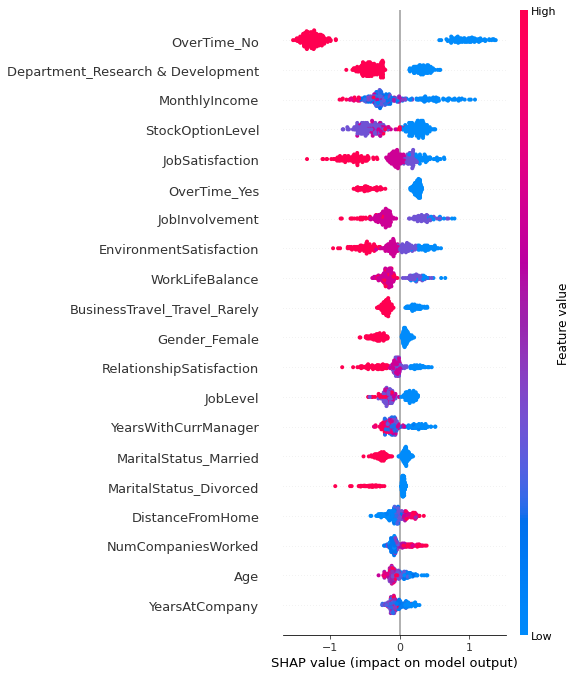

0.0
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


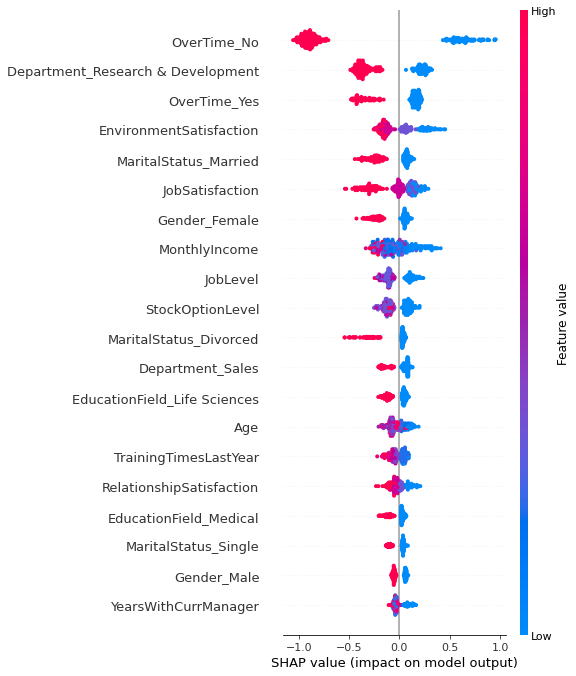

0.01
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


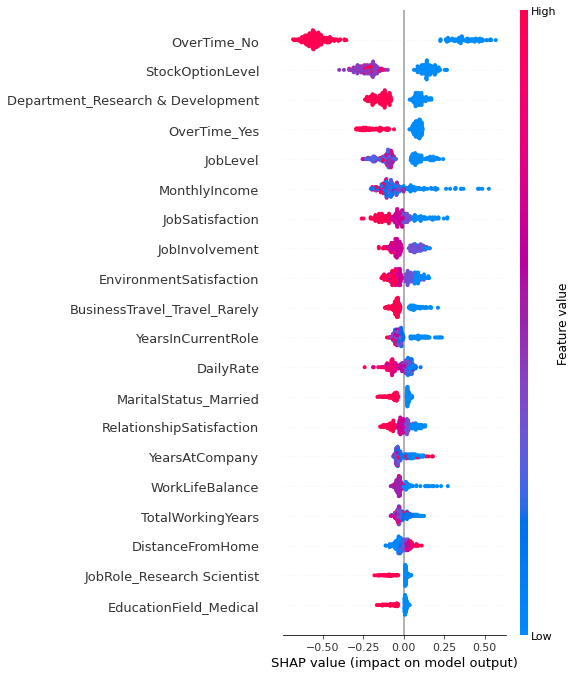

0.02
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


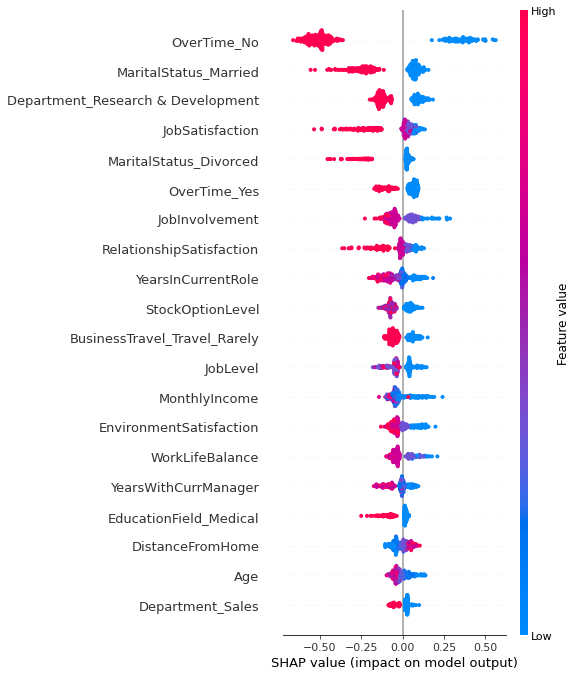

0.03
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


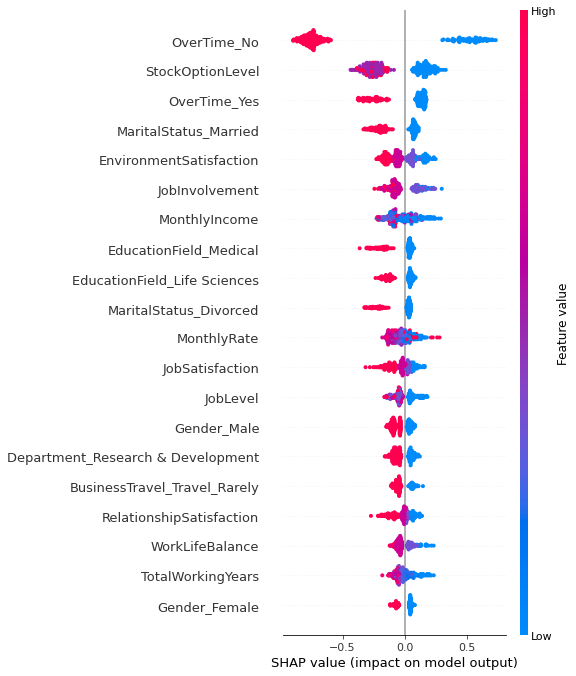

0.04
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


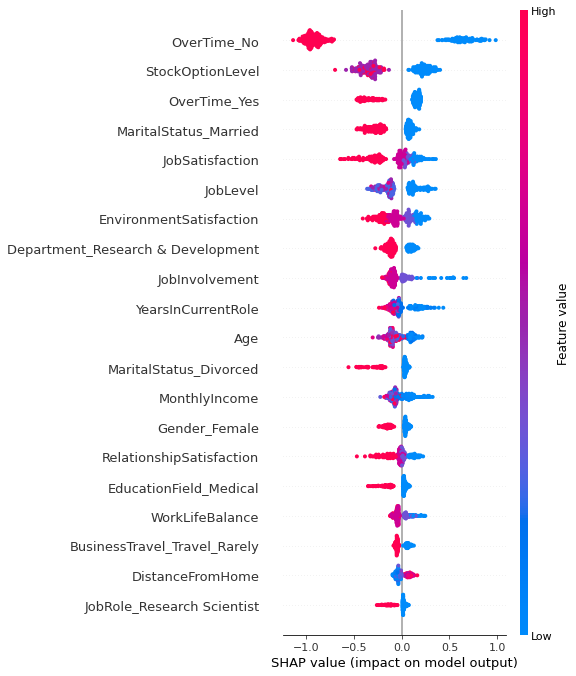

0.05
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


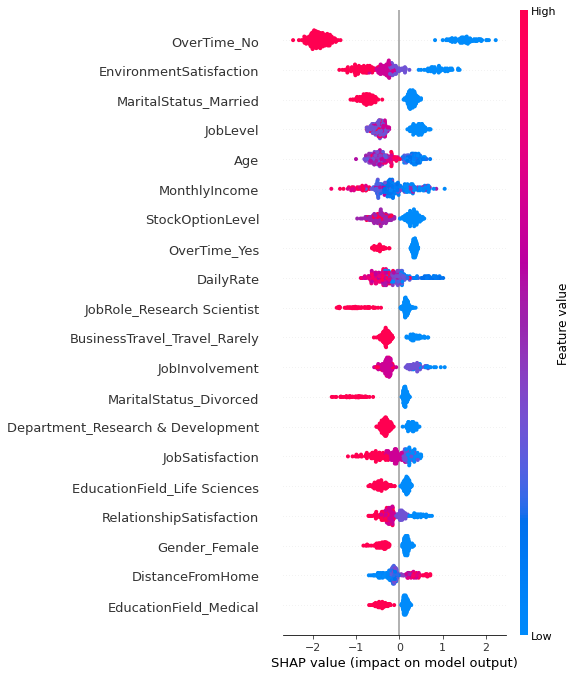

0.06
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


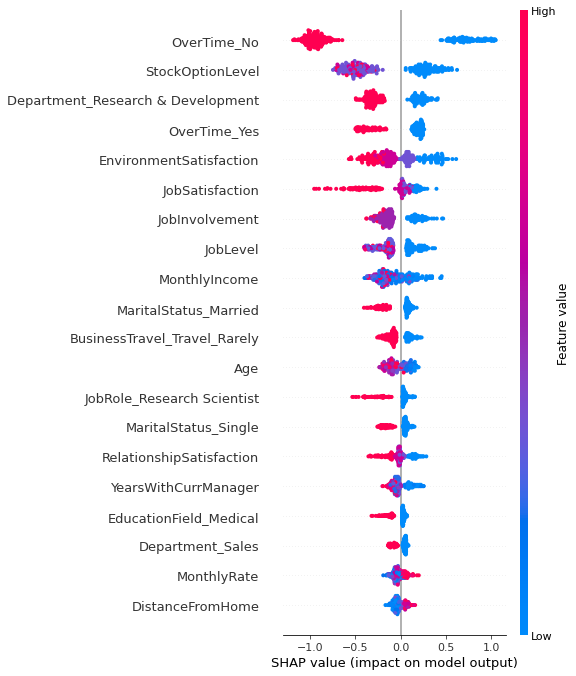

0.07
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


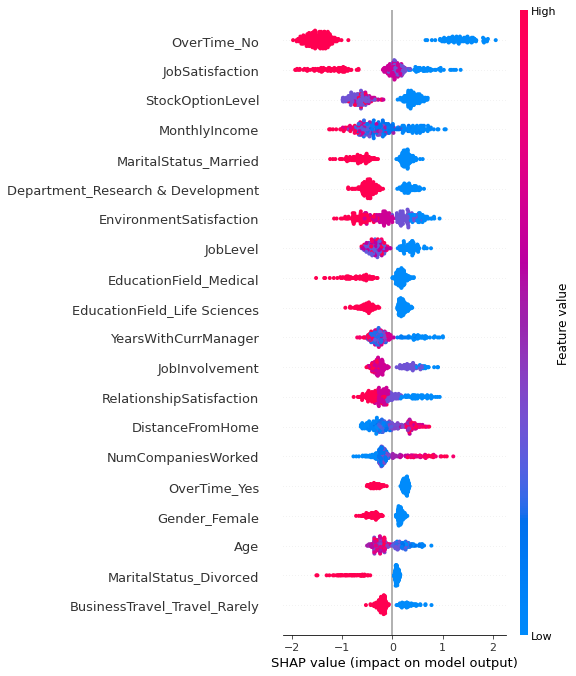

0.08
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


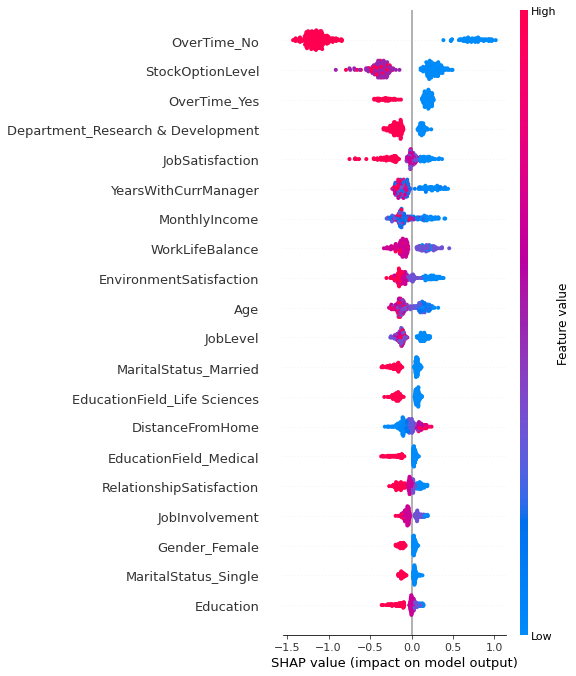

0.09
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


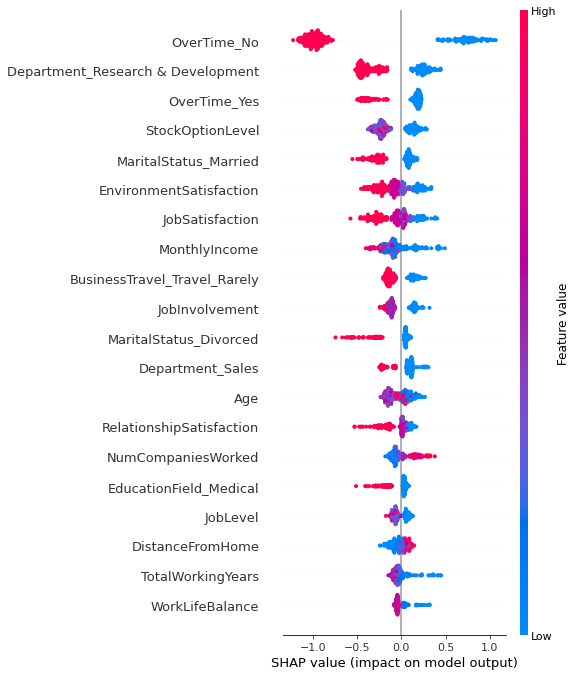

0.1
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


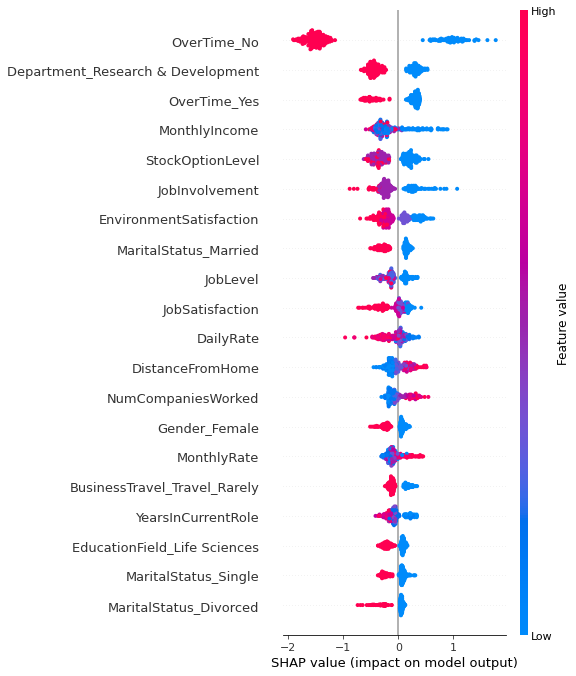

0.11
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


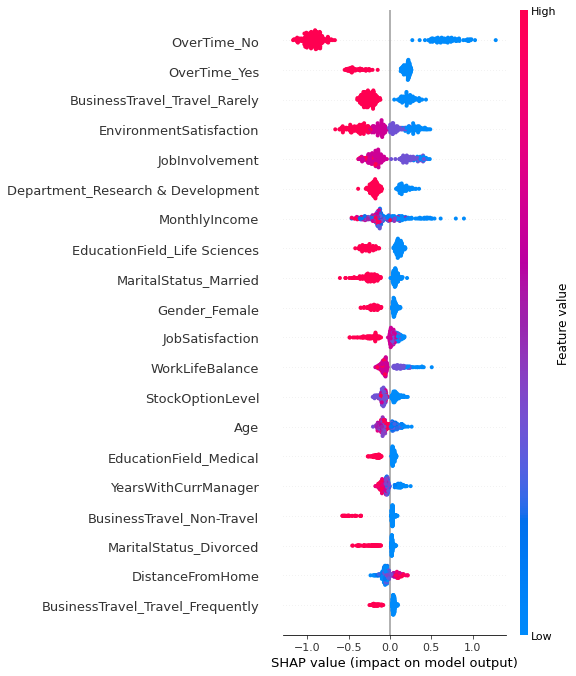

0.12
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


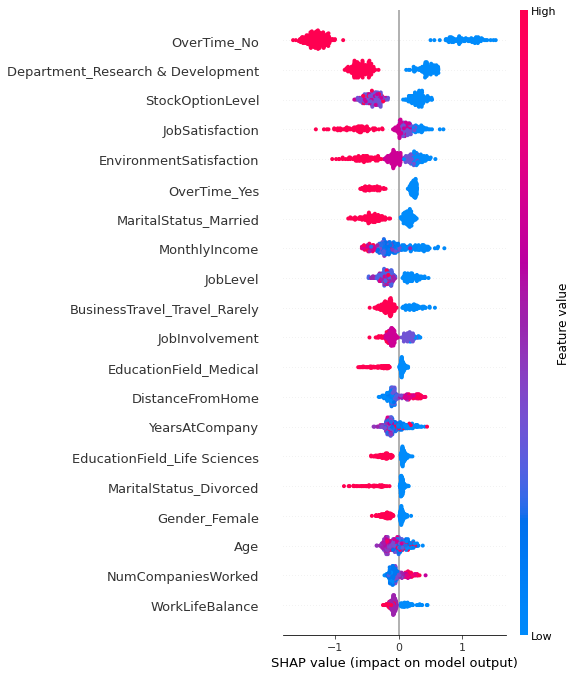

0.13
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


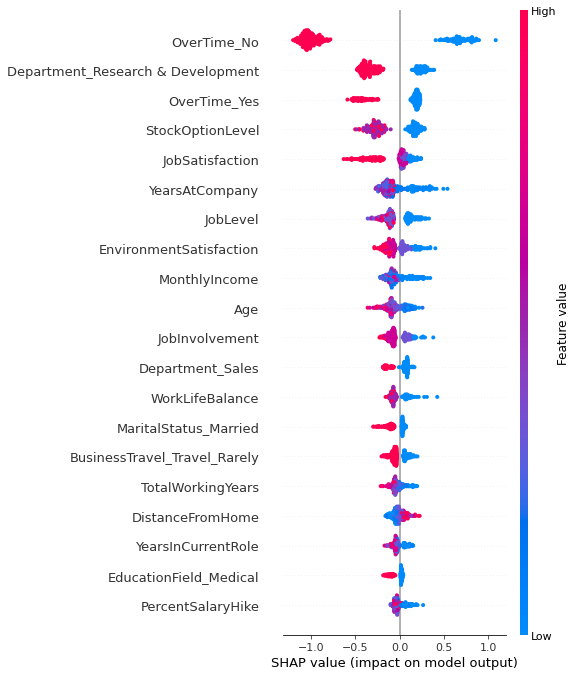

0.14
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


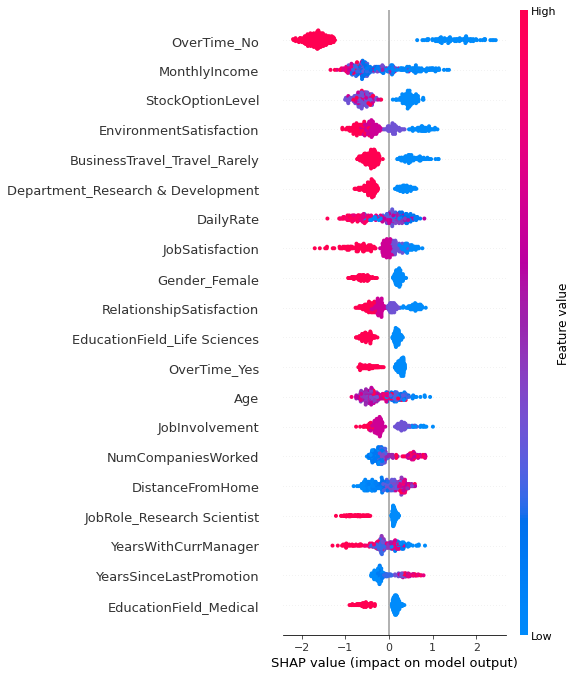

0.15
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


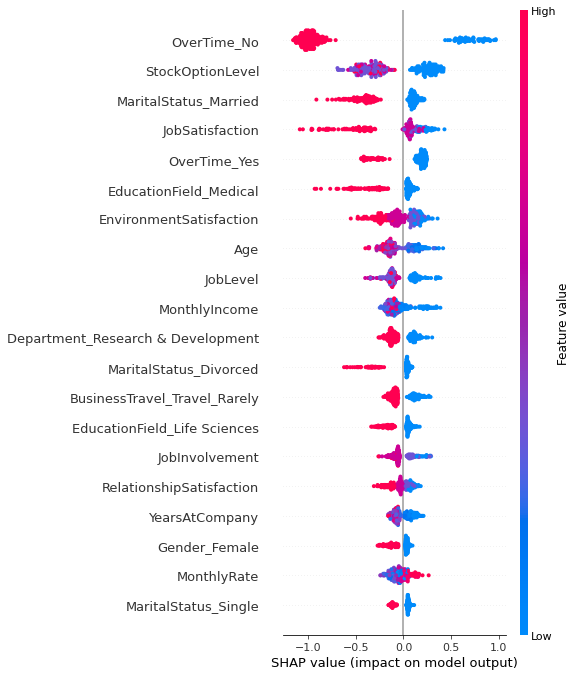

0.16
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


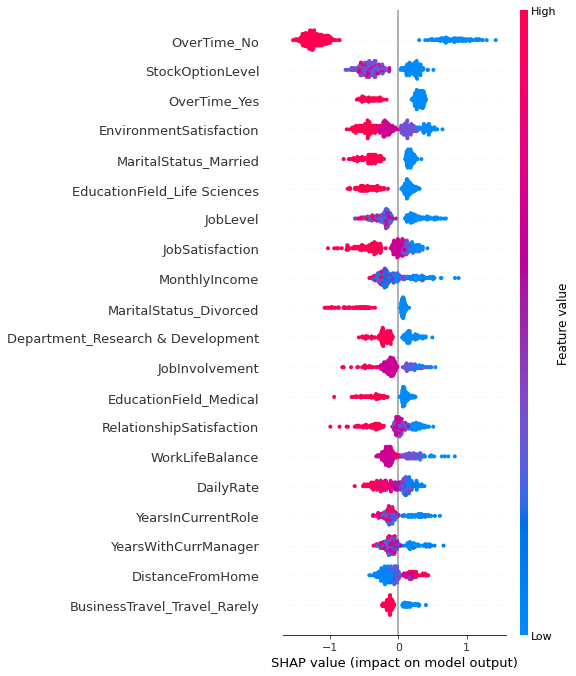

0.17
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


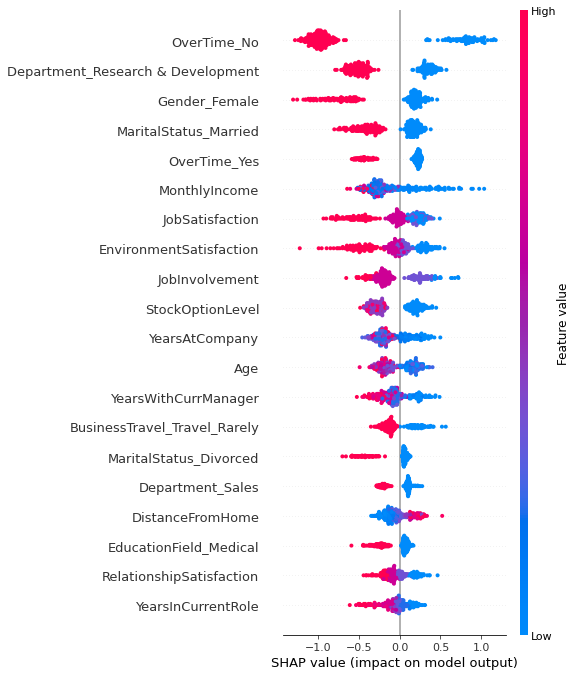

0.18
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


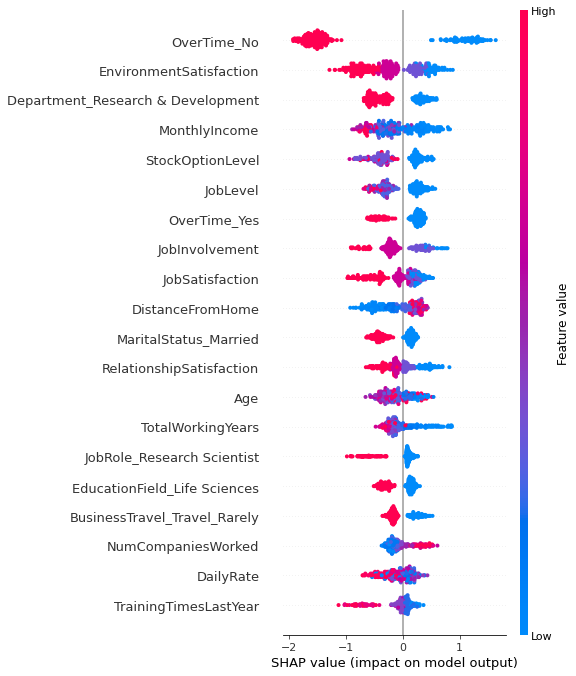

0.19
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


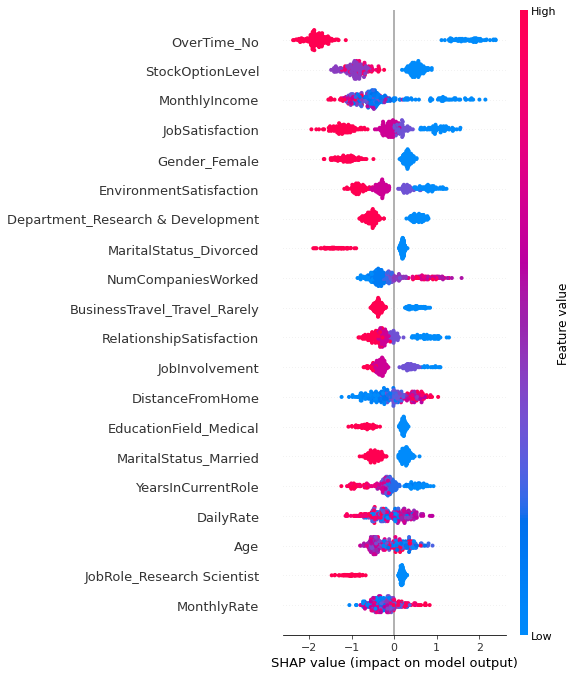

0.2
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


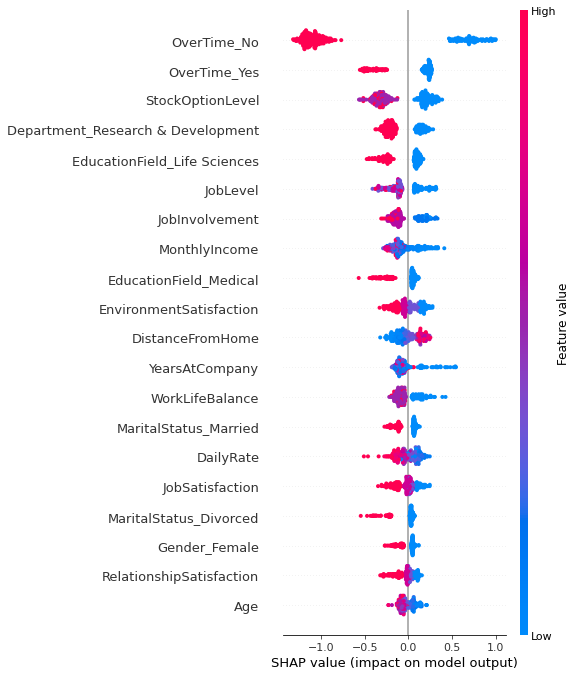

0.21
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


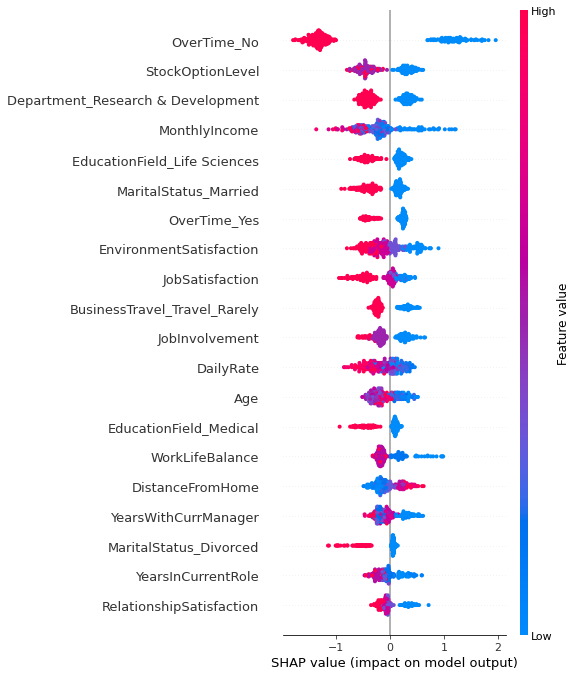

0.22
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


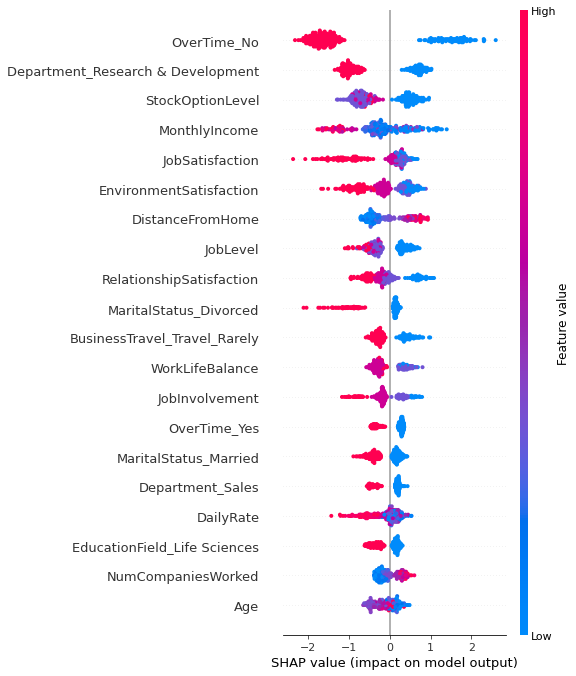

0.23
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


In [ ]:
#4. Model Training and Evaluation: XGBoost, SMOTE
Best_params_list = []
Best_models_list = []
Val_accuracies = []
Test_accuracies = []
Feature_Importances_List = []

for i in range(len(loop_rns)):
    
    #Initialize a model
    model_XGBoost = xgboost.XGBClassifier(objective="binary:logistic", random_state=loop_rns[i])
    
    # Initialize GridSearch using parameters passed into function
    grid_search = GridSearchCV(estimator=model_XGBoost, param_grid=param_grid_XGBoost,
                               cv=5, n_jobs=-1, verbose=2, scoring='accuracy', error_score ='raise') #use all available cores: n_jobs = -1

    # Fit to the training data - smotes takes training data in as input
    grid_search.fit(smotes[i][0],smotes[i][1]) #corresponds to the x_train and y_train data

    # Get the best parameters, show them to the world
    best_params = grid_search.best_params_
    Best_params_list.append(best_params)
    Best_models_list.append(best_model)
    #print(f'Best Parameters: {best_params}')

    # Evaluate the best model on the validation data
    best_model = grid_search.best_estimator_
    validation_predictions = best_model.predict(splits_list[i][1])
    validation_accuracy = accuracy_score(splits_list[i][4], validation_predictions)
    #print("Validation Accuracy: ", validation_accuracy)
    Val_accuracies.append(validation_accuracy)

    # Then evaluate on the test set
    test_predictions = best_model.predict(splits_list[i][2])
    test_accuracy = accuracy_score(splits_list[i][5], test_predictions)
    #print(f'Test Accuracy: {test_accuracy}')
    Test_accuracies.append(test_accuracy)
    
    feature_importances = best_model.feature_importances_
    Feature_Importances_List.append(feature_importances)
    
    explainer = shap.Explainer(best_model)
    shap_values = explainer(splits_list[i][1]) # Assuming X_val is the validation features for the current loop

    # Plot summary of SHAP values
    shap.summary_plot(shap_values, splits_list[i][1])
    #this was a bad idea to do inside of a loop
    
    print(i/len(loop_rns))
    
#Get mean accuracies
print("Mean Validation Accuracy: ", np.mean(Val_accuracies))
print("Mean Test Accuracy: ", np.mean(Test_accuracies))

#Visualize mean feature importances
mean_importances = np.mean(feature_importances_list, axis=0)
plt.bar(range(len(mean_importances)), mean_importances)
plt.xticks(range(len(mean_importances)), feature_names, rotation=90) # Assuming feature_names is a list of your feature names
plt.show()

In [ ]:
#4. Model Training and Evaluation: XGBoost, random resampling

Best_params_list_random_oversample = []
Val_accuracies_random_oversample = []
Test_accuracies_random_oversample = []

for i in range(len(loop_rns)):
    
    #Initialize a model
    model_XGBoost = xgb.XGBClassifier(objective="binary:logistic", random_state=loop_rns[i])
    
    # Initialize GridSearch using parameters passed into function
    grid_search = GridSearchCV(estimator=model_XGBoost, param_grid=param_grid_XGBoost,
                               cv=5, n_jobs=-1, verbose=2, scoring='accuracy', error_score ='raise') #use all available cores: n_jobs = -1

    # Fit to the training data
    grid_search.fit(oversamples[i][0], oversamples[i][1]) #corresponds to the x_train and y_train data from upsampling

    # Get the best parameters, show them to the world
    best_params = grid_search.best_params_
    print(f'Best Parameters: {best_params}')
    Best_params_list_random_oversample.append(best_params)

    # Evaluate the best model on the validation data
    best_model = grid_search.best_estimator_
    validation_predictions = best_model.predict(splits_list[i][1])
    validation_accuracy = accuracy_score(splits_list[i][4], validation_predictions)
    print("Validation Accuracy: ", validation_accuracy)
    Val_accuracies_random_oversample.append(validation_accuracy)
    
    # Then evaluate on the test set
    test_predictions = best_model.predict(splits_list[i][2])
    test_accuracy = accuracy_score(splits_list[i][5], test_predictions)
    print(f'Test Accuracy: {test_accuracy}')
    Test_accuracies_random_oversample.append(test_accuracy)
    
print("Mean Validation Accuracy: ", np.mean(Val_accuracies_random_oversample))
print("Mean Test Accuracy: ", np.mean(Test_accuracies_random_oversample))

In [ ]:
#4. Model Training and Evaluation: XGBoost, Downsampling Majority Class

Best_params_list_downsampled = []
Val_accuracies_downsampled = []
Test_accuracies_downsampled = []

for i in range(len(loop_rns)):
    
    #Initialize a model
    model_XGBoost = xgb.XGBClassifier(objective="binary:logistic", random_state=loop_rns[i])
    
    # Initialize GridSearch using parameters passed into function
    grid_search = GridSearchCV(estimator=model_XGBoost, param_grid=param_grid_XGBoost,
                               cv=5, n_jobs=-1, verbose=2, scoring='accuracy', error_score ='raise') #use all available cores: n_jobs = -1

    # Fit to the training data
    grid_search.fit(downsampleds[i][0], downsampleds[i][1]) #corresponds to the x_train and y_train data from the 500 down-sampled training sets

    # Get the best parameters, show them to the world
    best_params = grid_search.best_params_
    print(f'Best Parameters: {best_params}')
    Best_params_list_downsampled.append(best_params)

    # Evaluate the best model on the validation data
    best_model = grid_search.best_estimator_
    validation_predictions = best_model.predict(splits_list[i][1])
    validation_accuracy = accuracy_score(splits_list[i][4], validation_predictions)
    print("Validation Accuracy: ", validation_accuracy)
    Val_accuracies_downsampled.append(validation_accuracy)

    # Then evaluate on the test set
    test_predictions = best_model.predict(splits_list[i][2])
    test_accuracy = accuracy_score(splits_list[i][5], test_predictions)
    print(f'Test Accuracy: {test_accuracy}')
    Test_accuracies_downsampled.append(test_accuracy)
    
print("Mean Validation Accuracy: ", np.mean(Val_accuracies_random_oversample))
print("Mean Test Accuracy: ", np.mean(Test_accuracies_random_oversample))

In [ ]:
#4. Model Training and Evaluation: XGBoost, Changing Parameters to handle class imbalance

Best_params_scale_pos_weight = []
Val_accuracies_scale_pos_weight = []
Test_accuracies_scale_pos_weight = []

for n in range(len(loop_rns)):
    #fit weight to training data breakdown
    scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

    #change model specifications for this one to incorporate scaling weights    
    model_XGBoost = xgboost.XGBClassifier(objective="binary:logistic", scale_pos_weight=scale_pos_weight, random_state=loop_rns[i])

    # Initialize GridSearch using parameters passed into function
    grid_search = GridSearchCV(estimator=model_XGBoost, param_grid=param_grid_XGBoost,
                               cv=5, n_jobs=-1, verbose=2, scoring='accuracy', error_score ='raise') #use all available cores: n_jobs = -1

    # Fit to the training data
    grid_search.fit(splits_list[i][0], splits_list[i][3]) #just run on normal training set

    # Get the best parameters, show them to the world
    best_params = grid_search.best_params_
    print(f'Best Parameters: {best_params}')
    Best_params_scale_pos_weight.append(best_params)
    
    # Evaluate the best model on the validation data
    best_model = grid_search.best_estimator_
    validation_predictions = best_model.predict(splits_list[i][1])
    validation_accuracy = accuracy_score(splits_list[i][4], validation_predictions)
    print("Validation Accuracy: ", validation_accuracy)
    Val_accuracies_scale_pos_weight.append(validation_accuracy)
    
    # Then evaluate on the test set
    test_predictions = best_model.predict(splits_list[i][2])
    test_accuracy = accuracy_score(splits_list[i][5], test_predictions)
    print(f'Test Accuracy: {test_accuracy}')
    Test_accuracies_scale_pos_weight.append(test_accuracy)
    
print("Mean Validation Accuracy: ", np.mean(Val_accuracies_random_oversample))
print("Mean Test Accuracy: ", np.mean(Test_accuracies_random_oversample))